# Caption with Attention: Encoder-Decoder Image Captioning

In [ ]:
# Contents

#     CLASSES:
#         FlickrDataset
#         Vocabulary
#         Encoder
#         Attention
#         Decoder
#         CaptionModel

#     STRUCTURE:
#         \Preprocessing/
#             FlickrDataset
#             Vocabulary
#                 Pretrained Embedding
#             get_loader(transform, loader(collate))
#         \Model/
#             CaptionModel
#                     |
#                     |----Encoder: Resnet[:-2] and avgpool
#                     |                 features and input cell states
#                     |
#                     |----Decoder: LSTM
#                     |             GloVe Embedding
#                     |             Attention
#                     |
#                     |----generate_caption()
#         \Training/Analysis/
#             plot_attention(): Image stacked with attention scores on each block


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models
import torchvision.transforms as transforms
import os
import pandas as pd
import spacy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# terminal command, change current directory
%cd drive/MyDrive/Colab\ Notebooks/ImageCaption

In [ ]:
# Colab Only
import spacy.cli
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
# Python Notebook Only

# !pip3 install -U spacy
# !python3 -m spacy download en_core_web_sm

## 1. Preprocessing

### 1.1 Dataset

In [ ]:
# get_loader.py
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform, topk=10000):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        self.img_ids = self.df["image"]
        self.captions = self.df["caption"]

        self.vocab = Vocabulary(topk)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert('RGB')
        img = self.transform(img)
        
        caption = self.captions[index]
        numericalized = self.vocab.numericalize(caption)    # numericalize=tokenize+'numericalize'
        numericalized = [self.vocab.stoi['<SOS>']] + numericalized
        numericalized.append(self.vocab.stoi['<EOS>'])

        return img, torch.tensor(numericalized)


### 1.2 Vocabulary

In [ ]:
# get_loader.py
class Vocabulary:
    def __init__(self, topk=20000):
        self.topk = topk
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.nlp = spacy.load("en_core_web_sm")

    def __len__(self):
        return len(self.itos)

    def tokenizer_eng(self, text):
        return [tok.text.lower() for tok in self.nlp.tokenizer(text)]
        
    def build_vocabulary(self, sentence_list):
        all_tokens = []
        count=0
        print('Number of example loaded:')
        for sentence in sentence_list:
            if count % 10000 == 9999:
                print(count+1)
            count+=1
            for word in self.tokenizer_eng(sentence):
                all_tokens.append(word)
        print(len(sentence_list)+1)
        counter = Counter(all_tokens)
        most_common = counter.most_common(self.topk)   # list of of (token, count)
        most_common = [tok for tok, count in most_common]
        tokens = sorted(most_common, key=lambda x: (counter[x], x), reverse=True)
        for num, tok in enumerate(tokens):
            self.itos[num+4] = tok
            self.stoi[tok] = num+4

    def numericalize(self, text):
        tokenized = self.tokenizer_eng(text)
        numericalized = [self.stoi[tok] if tok in self.stoi else self.stoi['<UNK>'] for tok in tokenized]
        return numericalized


In [ ]:
# Load glove from local file and form a dict
def get_glove_embedding():
    glove = pd.read_csv('glove.6B.200d.txt', sep=" ", quoting=3, header=None, index_col=0)
    glove_embedding = {key: val.values for key, val in glove.T.items()}
    return glove_embedding

In [ ]:
# build embedding matrix according to dataset
# embedding_dict

def build_embedding_matrix(itos, embedding_dict):
    embed_size = len(embedding_dict['a'])
    embedding_matrix = torch.empty((len(itos),embed_size))
    for index, word in enumerate(itos):
        if word in embedding_dict:
            embedding_matrix[index] = embedding_dict[word]
        else:
            torch.nn.init.normal_(embedding_matrix[index], std=0.4)
    return embedding_matrix

def create_embedding(embedding_matrix, trainable=False):
    vocab_size = embedding_matrix.shape[0]
    embed_size = embedding_matrix.shape[1]
    embedding_layer = nn.Embedding(vocab_size, embed_size)
    embedding_layer.load_state_dict({'weight': embedding_matrix})
    if not trainable:
        embedding_layer.weight.requires_grad = False
    return embedding_layer, embed_size, vocab_size


### 1.3 Loader

In [ ]:
# Class: get_loader
def get_loader(root_folder, annotation_file, transform, ratio=0.8, batch_size=32, num_workers=2, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform, topk=10000)
    #train_set, dev_set = torch.utils.data.random_split(dataset, [int(ratio*len(dataset)),len(dataset)-int(ratio*len(dataset))])
    pad_idx = dataset.vocab.stoi["<PAD>"]
    loader = DataLoader(
                        dataset=dataset,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=shuffle,
                        pin_memory=pin_memory,
                        # drop_last=True,
                        collate_fn=Collate(pad_idx=pad_idx)  # call Collate
    )
    return loader, dataset


### 1.4 Utils for Preprocessing

In [ ]:
# Class: get_loader
class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        # print('img_pre:',type(imgs))
        imgs = torch.cat(imgs, dim=0)
        # print('img_post:',type(imgs))
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        # print('targets.shape:', targets.shape)
        return imgs, targets


In [ ]:
# Class: get_loader
def get_transform():
    transform = transforms.Compose([
                                   transforms.Resize(224), # transforms.Resize(256)
                                   transforms.CenterCrop(224), # transforms.RandomCrop(224)
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
                                  ])
    return transform

## 2. Model

### 2.1 Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, freeze_resnet=True, dropout=0.2):
        super(Encoder, self).__init__()
        self.ResNet_feature = nn.Sequential(*(list(torchvision.models.resnet50(pretrained=True).children())[:-2]))
        self.avgpool = torchvision.models.resnet50(pretrained=True).avgpool
        self.linear = nn.Linear(2048, hidden_size) # pass in to cell_state
        self.dropout = nn.Dropout(dropout)
        
        if freeze_resnet:
            for param in self.ResNet_feature.parameters():
                param.requires_grad = False
    
    def forward(self, images):
        features = self.ResNet_feature(images)
        before_fc = self.avgpool(features)
        input_cell = F.relu(self.linear(before_fc.reshape(-1,2048)))  # batch x 2048
        input_cell = self.dropout(input_cell) # batch x hidden_size

        # features shape: (b,2048,7,7)=>(b,2048,49)=>(b,49,2048)
        features = features.reshape(features.shape[0], 2048, 49).permute(0,2,1)
        return features, input_cell


### 2.2 Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size, units):
        super(Attention, self).__init__()
        self.W_f = nn.Linear(2048, units)
        self.W_s = nn.Linear(2*hidden_size, units)
        self.W_att = nn.Linear(units, 1)

    def forward(self, features, states):
        # features = (b, 49, 2048)
        # states = ((1, b, h), (1, b, h))
        states = torch.cat(states, dim=-1) # (1, b, h*2)
        feature_units = self.W_f(features) #(b, 49, units)
        attention = torch.tanh(feature_units+self.W_s(states.permute(1,0,2))) # (b, 49, units) broadcast
        scores = self.W_att(attention)  # b x 49 x 1
        attention_weights = F.softmax(scores, dim=1)  # b x 49 x 1
        context_vector = attention_weights * feature_units # b x 49 x units, broadcast
        context_vector = torch.sum(context_vector, dim=1) # b x units
        return context_vector, attention_weights  # (b, units), (b x 49 x 1)
        


### 2.3 Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, units, vocab_size, freeze_embedding=True):
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.units = units
        self.vocab_size = vocab_size
        self.lstm = nn.LSTM(
                            input_size=embed_size + units,
                            hidden_size=hidden_size,
                            batch_first=True
                            )
        self.linear = nn.Linear(hidden_size, self.vocab_size)
        self.attention = Attention(hidden_size, self.units)

    def forward(self, word_vector, states, features):
        # word_vector (b, 1, emb)
        # states ((1, b, h), (1, b, h))
        context_vector, attention_weights = self.attention(features, states) # (b, units), (b x 49 x 1)
        context_vector = context_vector.unsqueeze(1)  # (b, 1, units)
        input = torch.cat((word_vector, context_vector), dim=-1) # (b, 1, emb+units)
        output, states = self.lstm(input, states)  # output:(b, 1, h), ((1, b, h), (1, b, h))
        logits = self.linear(output) # (b, 1, vocab)

        ####### ******** ########
        return states, logits, attention_weights
        ####### ******** ########


### 2.A Complete Model

In [ ]:
class CaptionModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, units,
                 freeze_resnet=True, freeze_embedding=True, dropout=0.2):
        super(CaptionModel, self).__init__()
        self.hidden_size = hidden_size
        self.units = units
        self.embedding, self.embed_size, self.vocab_size = create_embedding(embedding_matrix, trainable=not freeze_embedding)
        
        #self.embedding.weight.data.normal_()
        
        self.encoder = Encoder(self.units, freeze_resnet=freeze_resnet, dropout=dropout)
        self.decoder = Decoder(self.embed_size, hidden_size, units, vocab_size=self.vocab_size,
                               freeze_embedding=freeze_embedding)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, images, captions):
        features, input_cell = self.encoder(images) #(b, 49, 2048), (b, hidden)
        input_cell = input_cell.unsqueeze(0) # (1, b, hidden)
        #input_cell = torch.zeros_like(input_cell.unsqueeze(0)) # (1, b, hidden)
        input_hidden = torch.zeros_like(input_cell)
        states = (input_hidden, input_cell)

        # all_logits:(b, length, vocab_size)
        all_logits = torch.zeros((captions.shape[0], captions.shape[1], self.vocab_size)).to(device)
        embeddings = self.embedding(captions) #embeddings:(b, length, emb)
        for idx in range(captions.shape[1]): #captions:(b, length)
            word_vector = embeddings[:, idx, :].unsqueeze(1)  # (b, 1, emb)
            states, logits, _ = self.decoder(word_vector, states, features)  # logits:(b, 1, vocab)
            all_logits[:, idx, :] = logits.squeeze(1)

        return all_logits  # (b, length, vocab_size)

    def generate_caption(self, images, vocab, max_length=30):
        features, input_cell = self.encoder(images) #(b, 49, 2048), (b, hidden)
        input_cell = input_cell.unsqueeze(0) # (1, b, hidden)
        #input_cell = torch.zeros_like(input_cell.unsqueeze(0))
        input_hidden = torch.zeros_like(input_cell)
        states = (input_hidden, input_cell)

        # predicted_caption = (b, l)
        predicted_caption = torch.zeros((images.shape[0], max_length)) # fill with 0 => '<PAD>'

        batch_size = images.shape[0]
        single_word_vector = self.embedding(torch.tensor(vocab.stoi['<SOS>']).to(device)) # (1, emb)
        word_vector = single_word_vector.unsqueeze(0).repeat(batch_size, 1, 1) #(b, 1, emb)
        attentions = torch.zeros((images.shape[0], max_length, 49)) #(b, max_1ength, 49)

        for idx in range(max_length): #captions:(b, length)
            states, logits, attention_weights = self.decoder(word_vector, states, features)  # logits:(b, 1, vocab)
            # (b, 49, 1) => (b, 49)
            attention_weights = attention_weights.squeeze(-1)
            attentions[:, idx, :] = attention_weights
            predicted = torch.argmax(logits, dim=-1) # predicted:(b, 1)
            predicted_caption[:, idx] = predicted.squeeze(1) 
            word_vector = self.embedding(predicted) # pass in (b, 1), get (b, 1, emb)

        # caption_list: (b, max_length)
        caption_list = predicted_caption.tolist()
        attention_array = attentions.detach().numpy() #(b, max_1ength, 49)

        result_list = []
        attention_list = []
        for batch_idx in range(len(caption_list)):
            line = caption_list[batch_idx]
            line_result = []
            for idx in range(len(line)):
                num = line[idx]
                if vocab.itos[num] != '<EOS>':
                    line_result.append(vocab.itos[num])
                else:
                    append_att = attention_array[batch_idx, :idx, :].reshape(idx, 7, 7) 
                    attention_list.append(append_att) #[b]*(*real_length, 7, 7)
                    break
            result_list.append(line_result)
        return result_list, attention_list


        

## 3. Training

### 3.1 Training Fuction

In [ ]:
# Define Train and Evaluate Function

def train(model, device, loader, optimizer, criterion, epoch, log_interval=1, dry_run=False, save=False):
    model.to(device)
    criterion.to(device)
    model.train()
    best_loss = np.inf
    for ep in range(1, epoch+1):
        current = 0
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data, target[:,:-1])
            loss = criterion(output.reshape(-1, output.shape[2]), target[:,1:].reshape(-1)) #(b*l, vocab), (b*l)
            loss.backward()
            optimizer.step()
            current += len(data)
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} \t[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, current, len(loader.dataset),
                    100. * current / len(loader.dataset), loss.item()))
                if dry_run:
                    break


### 3.2 Get Dataset Loader

In [ ]:
# Prepare Dataset
root_folder = 'flickr8k/images'
annotation_file = 'flickr8k/captions.txt'
train_dev_ratio = 0.8
transform = get_transform()
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loader, dataset = get_loader(root_folder, annotation_file, transform,
                             ratio=train_dev_ratio, batch_size=batch_size)

Number of example loaded:
10000
20000
30000
40000
40456


In [ ]:
# Prepare Glove Embedding
glove_embedding = get_glove_embedding()

### 3.3 Create Model

In [ ]:
######################################
# !!! Section for model creation !!! #
######################################

hidden_size = 512
units = 512

embedding_matrix = build_embedding_matrix(dataset.vocab.itos, glove_embedding) # arguments(list, dictionary)
model = CaptionModel(embedding_matrix, hidden_size, units,
                     freeze_resnet=True, freeze_embedding=False)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

11202680

### 3.4 Hyperparameters and Train

In [ ]:
# model
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train(model, device, loader, optimizer, criterion, epoch=5, log_interval=10, save=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 	[32/40455 (0%)]	Loss: 9.037376
Train Epoch: 1 	[352/40455 (1%)]	Loss: 5.688612
Train Epoch: 1 	[672/40455 (2%)]	Loss: 5.271122
Train Epoch: 1 	[992/40455 (2%)]	Loss: 5.388086
Train Epoch: 1 	[1312/40455 (3%)]	Loss: 5.322233
Train Epoch: 1 	[1632/40455 (4%)]	Loss: 5.505995
Train Epoch: 1 	[1952/40455 (5%)]	Loss: 5.126975
Train Epoch: 1 	[2272/40455 (6%)]	Loss: 5.275129
Train Epoch: 1 	[2592/40455 (6%)]	Loss: 5.145700
Train Epoch: 1 	[2912/40455 (7%)]	Loss: 4.795283
Train Epoch: 1 	[3232/40455 (8%)]	Loss: 5.119340
Train Epoch: 1 	[3552/40455 (9%)]	Loss: 5.070478
Train Epoch: 1 	[3872/40455 (10%)]	Loss: 5.187338
Train Epoch: 1 	[4192/40455 (10%)]	Loss: 5.021696
Train Epoch: 1 	[4512/40455 (11%)]	Loss: 4.896394
Train Epoch: 1 	[4832/40455 (12%)]	Loss: 4.913516
Train Epoch: 1 	[5152/40455 (13%)]	Loss: 4.808576
Train Epoch: 1 	[5472/40455 (14%)]	Loss: 4.809190
Train Epoch: 1 	[5792/40455 (14%)]	Loss: 4.975369
Train Epoch: 1 	[6112/40455 (15%)]	Loss: 4.979634
Train Epoch: 1 	[

## 4. Analysis

In [ ]:
# plot result
def plot_attention(image, result, attention):
    temp_image = np.array(image)

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention[i], (7, 7))
        grid_size = max(np.ceil(len_result/2), 1)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

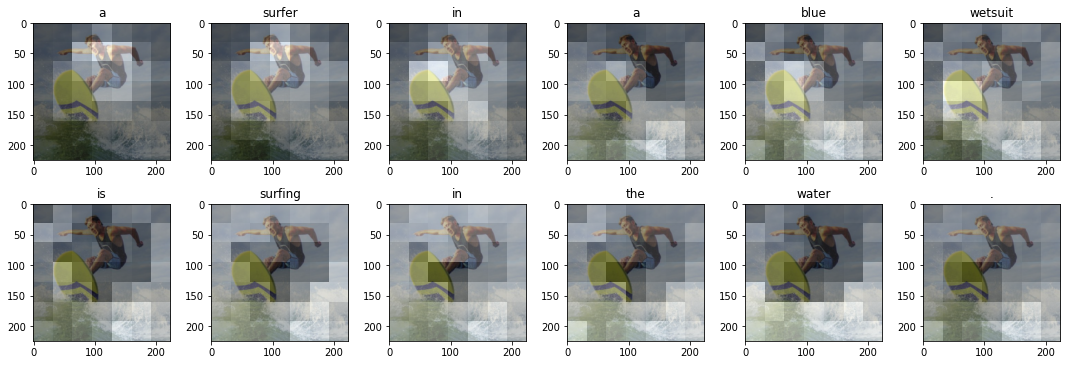

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
transform = get_transform()

# imgs: dog, surf, men, random, cutie
img1 = Image.open("test/surf.jpg").convert("RGB")
img1_tensor = transform(img1) # input for model
img1_show = transforms.CenterCrop((224,224))(transforms.Resize(224)(img1)) # for display
generated_caption, attention = model.generate_caption(img1_tensor.unsqueeze(0).to(device), dataset.vocab)
generated_caption = generated_caption[0]
attention = attention[0]
plot_attention(image=img1_show, result=generated_caption, attention=attention)

## 5. Save and Load

In [ ]:
torch.save(model.state_dict(), 'cp_h512_u512_resF_embN_2.pt')

In [ ]:
# for gpu
#model.load_state_dict(torch.load('cp_h512_u512_resF_embN_1.pt'))

# for cpu
model.load_state_dict(torch.load('cp_h512_u512_resF_embN.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
#!nvidia-smi